In [128]:
import re
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import itertools

In [2]:
plt.rcParams["figure.figsize"] = 12, 9

### Задание №1 Считаем распределение GC-состава

заметим, что риды в test.fq записаны в старом формате phred64. Сделаем функцию для определения phred33/64 при помощи регулярных выражений 

In [3]:
def old_phred_check(path_to_fastq):
    with open (path_to_fastq, 'r') as fastq_input:
        n_line = 0
        for line in fastq_input:
            if n_line == 3:
                if re.search('[\[\]\^P-Za-z]', line) != None:
                    return 64
                elif re.search('[:;0-9]', line) != None:
                    return 33
            n_line += 1
            if n_line == 4:
                n_line = 0
        return 33

In [4]:
old_phred_check('test.fastq')

64

In [5]:
old_phred_check('test3.fastq')

33

Функция непосредственно считающая GC состав.\
Отсеивает нуклеотиды слишком низкого качества, нижняя граница качества задается аргументом nucl_qual_thr (по умолчанию <20).\
В общем числе нуклеотидов плохие нуклеотиды тоже не учитываются

Использовать средний q-score для отсеивания ридов не очень хорошо, потому что зависимость между q-score и вероятностью ошибки нелинейна - https://www.drive5.com/usearch/manual/avgq.html  

Поэтому будем считать среднюю вероятность ошибки на рид - это ожидаемое число ошибок (exp_errors - сумма вероятностей ошибки для каждого нуклеотида) деленая на количество нуклеотидов в риде https://www.drive5.com/usearch/manual/exp_errs.html

In [81]:
def gc_percent(read, read_qual_thr, nucl_qual_thr, ascii_base):
    exp_errors = 0
    total_nucl = 0
    total_ok_nucl = 1
    gc_nucl = 0
    for idx, nucleotide in enumerate(read[0]):
        nucl_q_score = ord(read[1][idx]) - ascii_base
        total_nucl += 1
        exp_errors += 10**(-nucl_q_score/10)
        if nucl_q_score >= nucl_qual_thr:
            total_ok_nucl += 1
            if re.match('[GC]', nucleotide, re.IGNORECASE) != None:
                gc_nucl += 1
    if exp_errors / total_nucl <= 10**(-read_qual_thr/10):
        return gc_nucl*100 / total_ok_nucl
    else:
        return None
        

Главная функция, в read[0] хранятся нуклеотиды, в read[1] хранится их качество.\
Риды с низким средним качеством отсеиваются при сравненни с read_qual_thr\
Если заранее известно какой phred score использовался, то можно не тратить время на проверку и сразу добавить его в аргумент ascii_base

In [82]:
def gc_of_fastq(path_to_fastq, read_qual_thr=20, 
                nucl_qual_thr=20, ascii_base=None):
    if ascii_base == None:
        ascii_base = old_phred_check(path_to_fastq)
    with open (path_to_fastq, 'r') as fastq_input:
        n_line = 0
        read = []
        gc_counts = []
        for line in fastq_input:
            if n_line == 1 or n_line == 3:
                read.append(line.rstrip('\n'))
            n_line += 1
            if n_line == 4:
                gc = gc_percent(read, read_qual_thr, nucl_qual_thr, ascii_base)
                if gc != None:
                    gc_counts.append(gc)
                n_line = 0
                read = []
        return gc_counts

Строим гистограмму с кривой плотности для test.fastq и test3.fastq

In [83]:
def plot_gc_content(gc_counts):
    sns.displot(gc_counts, kde=True, bins=range(0, 100, 4))
    plt.xlabel("GC-content, %")
    plt.ylabel("Number of reads")
    plt.xticks(range(0, 100, 4))
    plt.tick_params(axis='x', which='major', labelsize=8)
    plt.show()

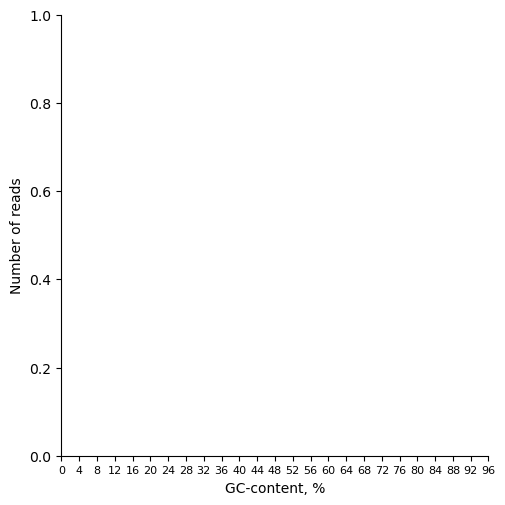

In [84]:
test1_gc_counts = gc_of_fastq('test.fastq', read_qual_thr=20, nucl_qual_thr=20)
plot_gc_content(test1_gc_counts)

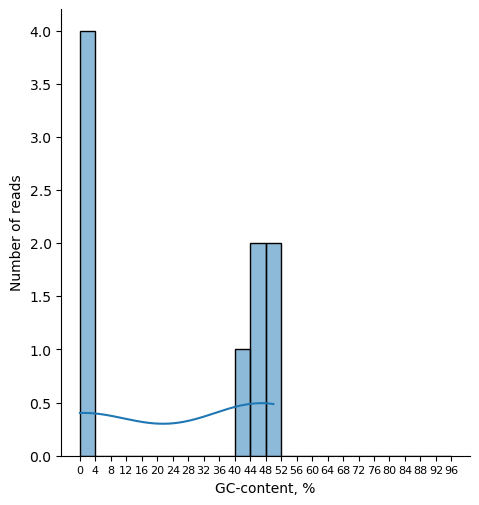

In [85]:
test1_gc_counts = gc_of_fastq('test.fastq', read_qual_thr=0, nucl_qual_thr=20)
plot_gc_content(test1_gc_counts)

Первый тестовый файл не прошел проверку на качество ридов

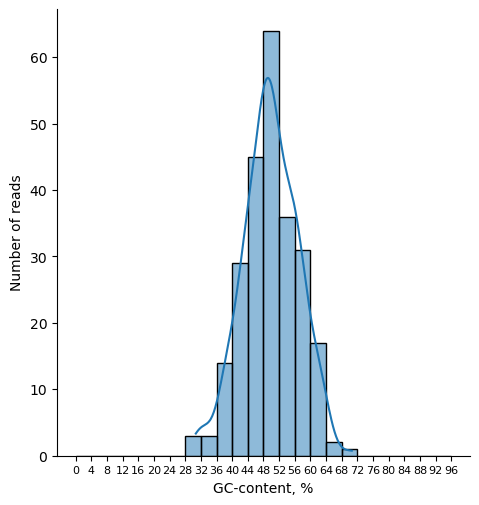

In [86]:
test3_gc_counts = gc_of_fastq('test3.fastq', read_qual_thr=20, nucl_qual_thr=20)
plot_gc_content(test3_gc_counts)

### Задание №2 Распределение качества


Создадим словарь, где ключ - номер нуклеотида в риде, а значение - список содержащий phred33 score для нуклеотидов в этой позиции во всех ридах. Не будем переводить Q-score в вероятности, потому что числа с большим количеством нулей плохо будет видно на графике.

In [12]:
def quality_distribution(path_to_fastq, ascii_base=None):
    if ascii_base == None:
        ascii_base = old_phred_check(path_to_fastq)
    with open (path_to_fastq, 'r') as fastq_input:
        n_line = 0
        Q_per_position = {}
        for line in fastq_input:
            if n_line == 3:
                for idx, symbol in enumerate(line.rstrip('\n')):
                    phred_score = ord(symbol) - ascii_base
                    position = idx + 1
                    if position not in Q_per_position.keys():
                        Q_per_position[position] = []
                    Q_per_position[position].append(phred_score)
            n_line += 1
            if n_line == 4:
                n_line = 0
        return Q_per_position

Нарисуем для каждой позиции в ридах боксплот для распределения Q-score как в FASTQC 

In [13]:
def boxplot_per_position(Q_dict):
    fig, ax = plt.subplots()
    ax.boxplot(Q_dict.values(), flierprops={'marker': '.', 'markersize': 0.5})
    ax.tick_params(axis='x', which='major', labelsize=6)
    ax.set_xticklabels(Q_dict.keys(), rotation=90)
    ax.margins(y=0)
    plt.ylim(0, 40)
    plt.xlabel("Position in read")
    plt.ylabel("Q-score")
    plt.show()

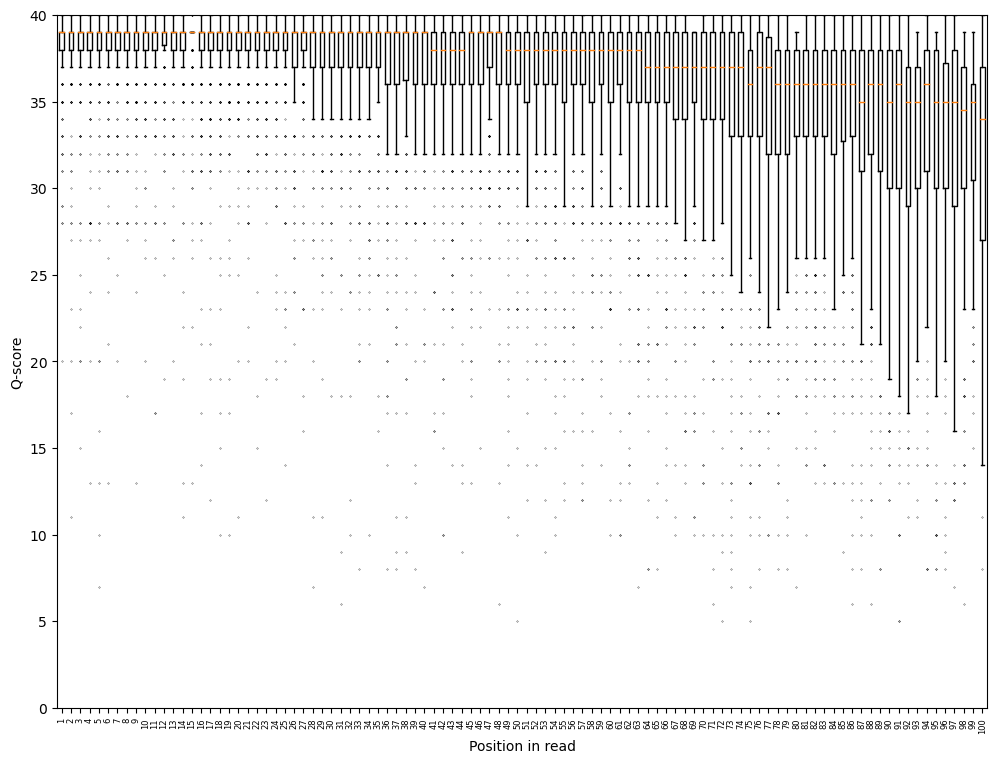

In [14]:
test3_dict = quality_distribution('test3.fastq')
boxplot_per_position(test3_dict)

### Задание №3. Сравниваем свое ~~убожество~~ изделие с FastQC

Анализ реальных данных в fastqc проведени с настройками по умолчанию, отчеты сохранены в папке fastqc_output 
сами реальные данные были скачаны на компьютер, к отчету их не прикрепляю, так как они тяжелые

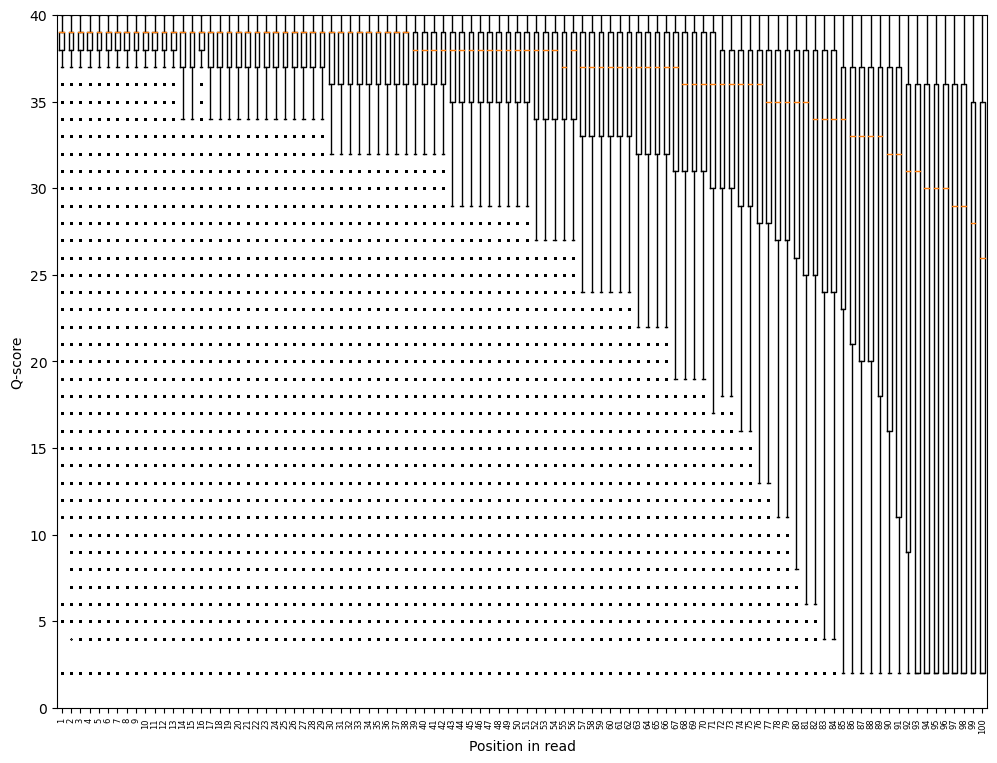

In [15]:
real_data_dict = quality_distribution('100x.1.fastq')
boxplot_per_position(real_data_dict)

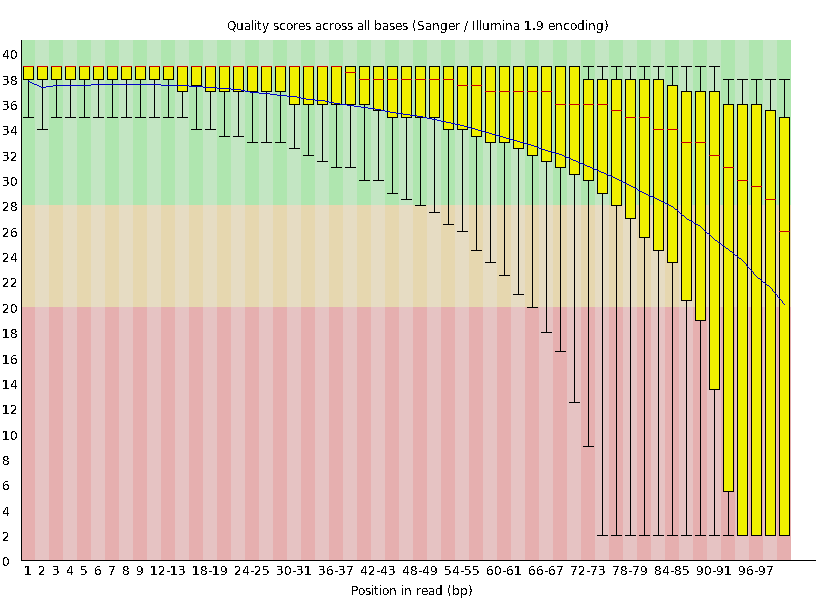

In [23]:
from IPython.display import Image
Image(filename='boxplot_100x.1.png') 

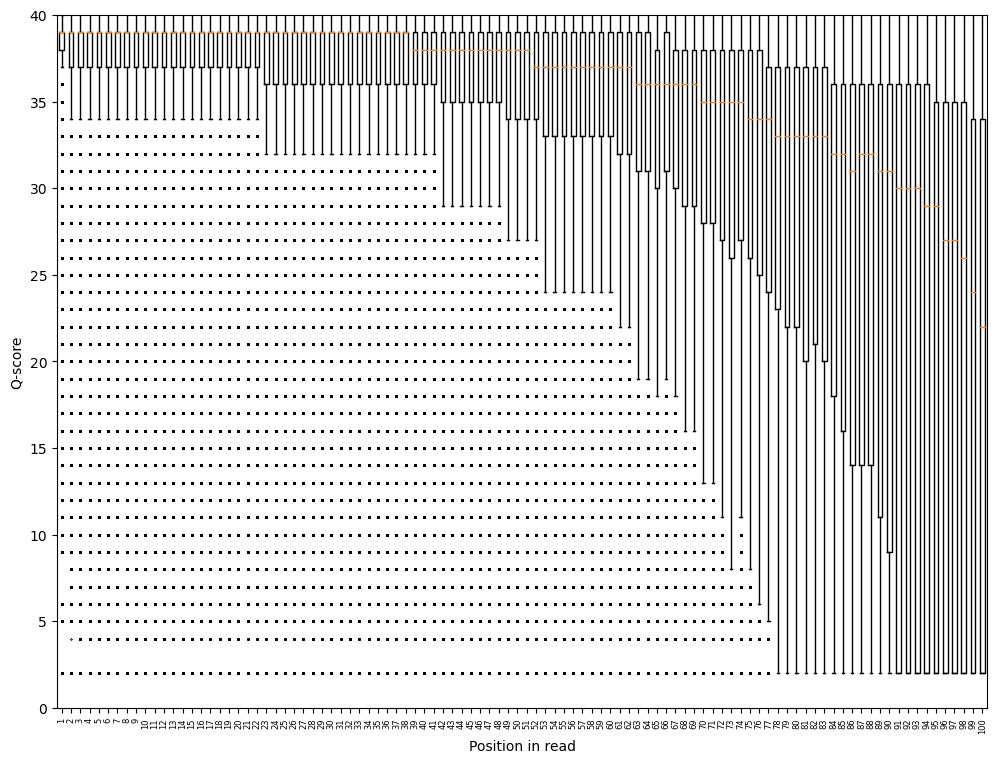

In [17]:
real_data_dict = quality_distribution('100x.2.fastq')
boxplot_per_position(real_data_dict)

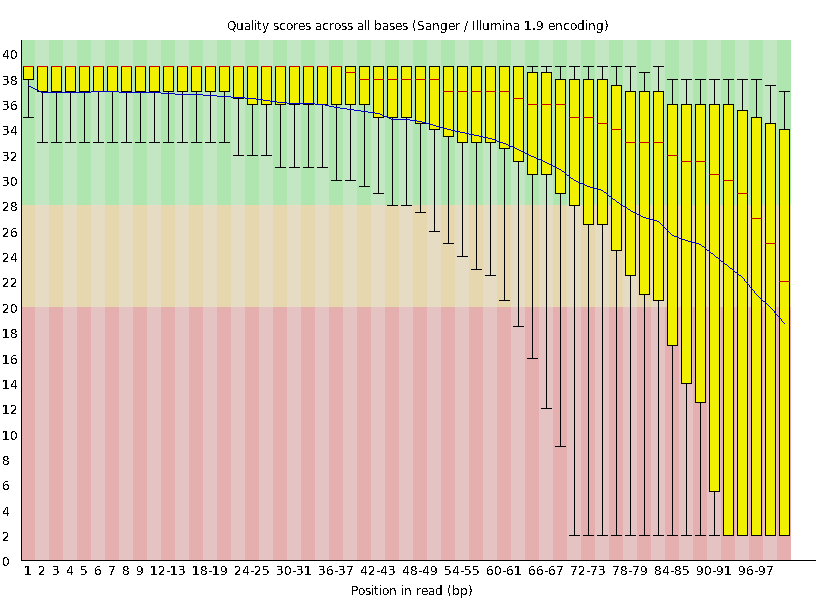

In [24]:
Image(filename='boxplot_100x.2.png') 

Форма графика в целом похожа, но мой вариант работает намного медленнее

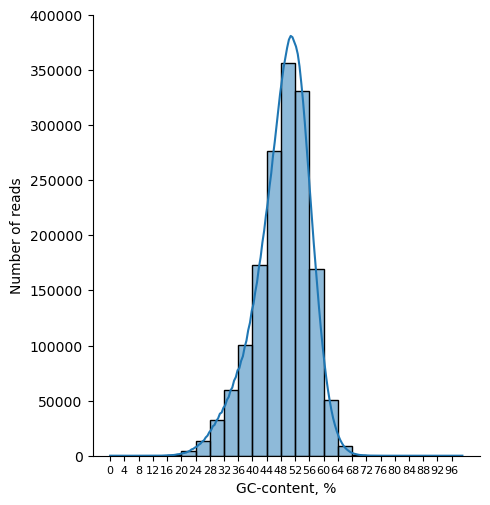

In [186]:
plot_gc_content(gc_of_fastq('100x.1.fastq', read_qual_thr=20, nucl_qual_thr=20))

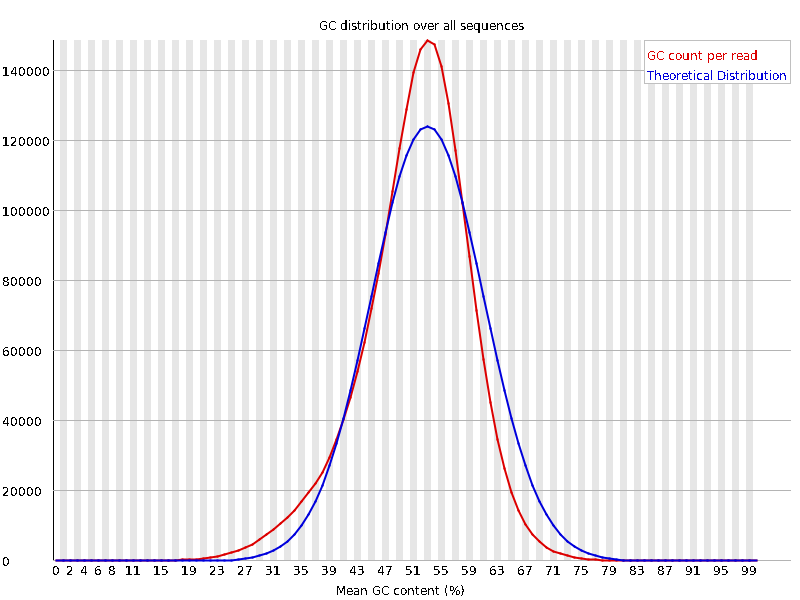

In [187]:
Image(filename='gc_100x.1.png') 

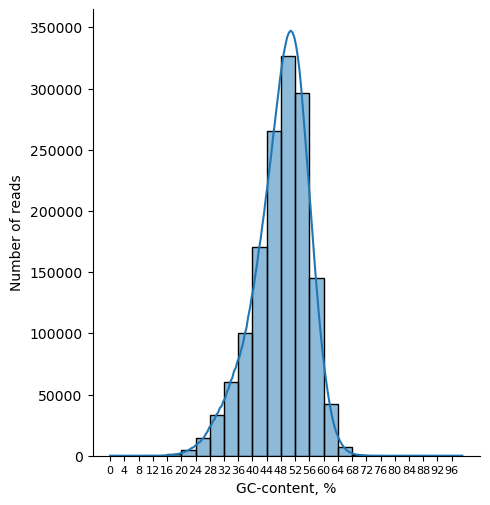

In [188]:
plot_gc_content(gc_of_fastq('100x.2.fastq', read_qual_thr=20, nucl_qual_thr=20))

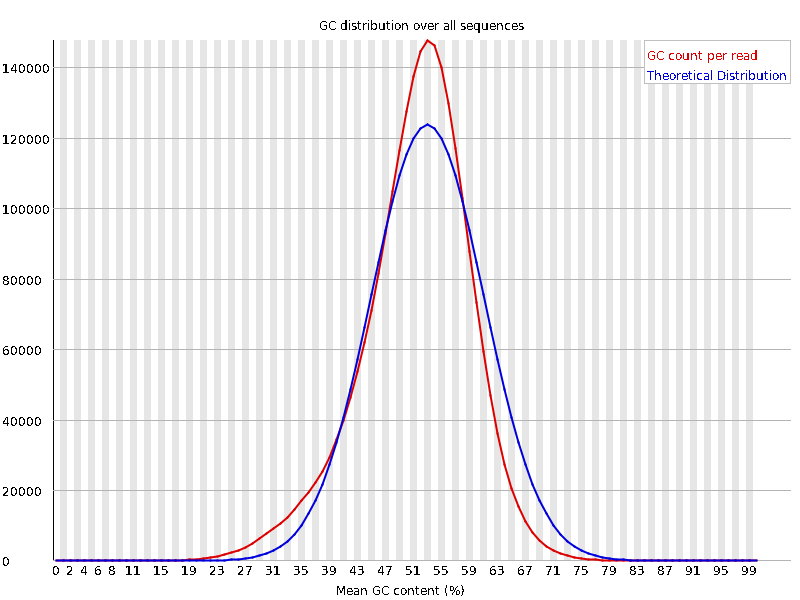

In [189]:
Image(filename='gc_100x.2.png') 

### Задание №4 Спектры k-меров

Сгенерируем словарь k-меров с длиной k, где ключ - k-мер, а значение - сколько раз k-мер встретился в нашей последовательности

In [145]:
def generate_kmer_dict(k):
    alphabet = ['G','C','T','A']
    kmer_dict = dict.fromkeys([''.join(kmer) for kmer in itertools.product(alphabet, repeat=k)], 0)
    return kmer_dict

При помощи магии регулярных выражений считаем сколько раз наша подстрока (k-мер) встречается в строке рида с учетом перекрываний и записываем эти значения в наш словарь

In [150]:
def count_kmers_read(kmer_dict, read):
    for kmer in kmer_dict.keys():
        pattern = f'(?=({kmer}))'
        matches = re.finditer(pattern, read)
        kmer_dict[kmer] += len([match.group(1) for match in matches])
    return kmer_dict

Проходим нашей функцией по всему fastq и выдаем на выходе словарь с тем сколько раз встретился в нашем файле каждый k-мер

In [151]:
def count_kmers_fastq(path_to_fastq, k):
    kmer_dict = generate_kmer_dict(k)
    with open (path_to_fastq, 'r') as fastq_input:
        n_line = 0
        for line in fastq_input:
            if n_line == 1:
                kmer_dict = count_kmers_read(kmer_dict, line.rstrip('\n'))
            n_line += 1
            if n_line == 4:
                n_line = 0
        return kmer_dict

In [182]:
def plot_kmer_spectrum(kmers_dict):
    k = len(next(iter(kmers_dict)))
    plot = sns.kdeplot(x = list(kmers_dict.values()))
    plt.ylabel(f"{k}-mer fraction")
    plt.xlabel(f"{k}-mer multiplicity")
    plt.show(plot)

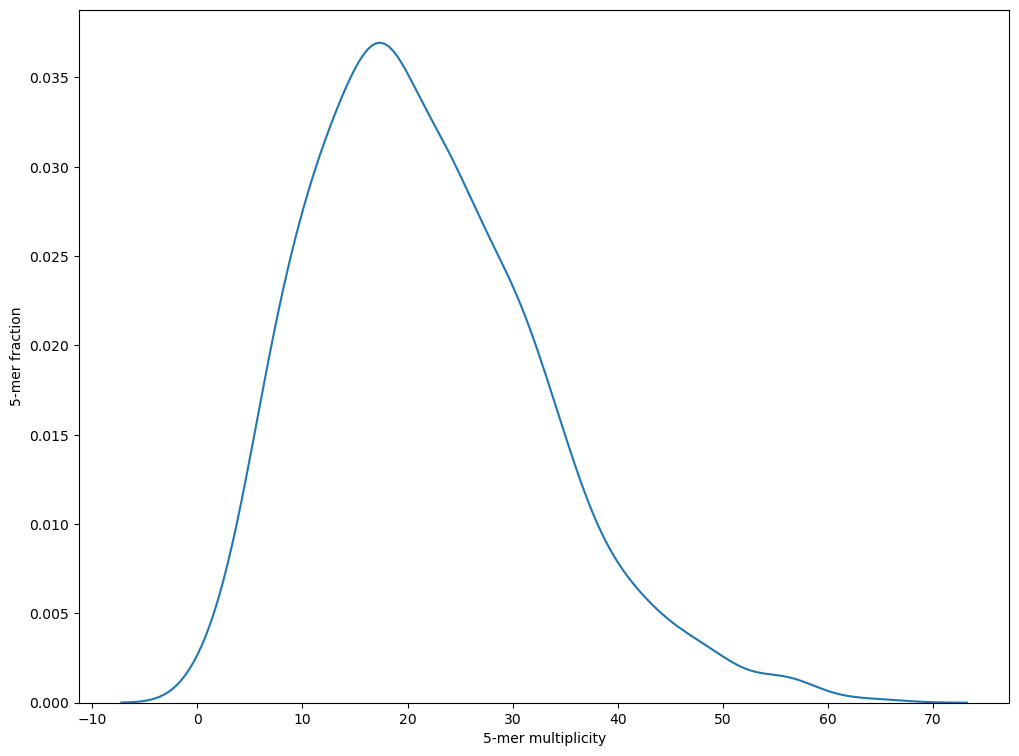

In [185]:
plot_kmer_spectrum(count_kmers_fastq('test3.fastq', 5))

Большой минус данного вариант - мы не учитываем Q-score нуклеотидов при подсчете k-меров (или это не нужно?)